<a href="https://colab.research.google.com/github/quenox/ML/blob/main/Time%20Series/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alumnos: Eugenio Peredo
Curso: Machine Learning

In [12]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [13]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [15]:
import warnings
warnings.filterwarnings('ignore')

### Load the data into Pandas DataFrame

In [236]:
import pandas as pd
url="https://raw.githubusercontent.com/castudil/Machine-Learning/main/data/GMAA-040218.csv"
#df = pd.read_csv(url, header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
#df.value = df.value.astype(int)

df = pd.read_csv("https://raw.githubusercontent.com/quenox/ML/main/diario5.csv", delimiter = ';', decimal=',', header=None, skiprows=0, parse_dates=[0], names=['period', 'value'])
print(df)




         period    value
0    2013-03-01   5.8750
1    2013-03-02  10.2500
2    2013-03-03  15.3333
3    2013-03-04  17.0417
4    2013-03-05  17.1250
...         ...      ...
3130 2021-11-25  10.0000
3131 2021-11-26   9.0000
3132 2021-11-27   7.0000
3133 2021-11-28   8.0000
3134 2021-11-29   8.0000

[3135 rows x 2 columns]


In [237]:
import numpy as np

train_range = df[(df.period < '2019-01-01')].index
test_range = df[(df.period >= '2019-01-01')].index

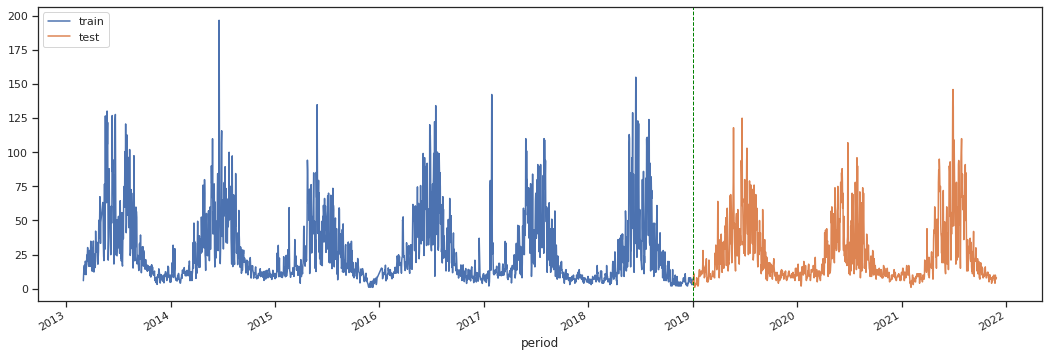

In [238]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/prophet-split.png'); ## recuerda crear la carpeta images si trabajas con Google Colab

In [241]:
from fbprophet import Prophet

In [258]:
df_prophet_train = df.loc[train_range][["period", "value"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    mcmc_samples=12,
    #growth='linear',
    interval_width=0.9
)

In [259]:
model.fit(df_prophet_train);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Make prediction

In [260]:
df_prophet_test = df.loc[test_range][["period", "value"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df.loc[test_range].value.values

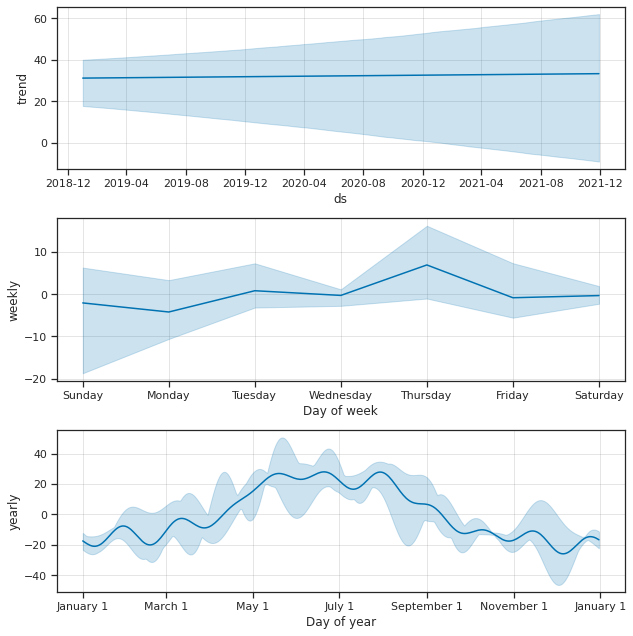

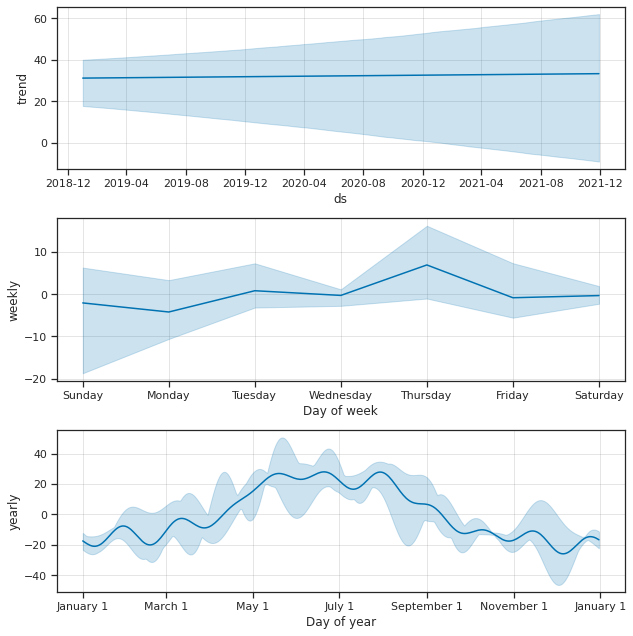

In [261]:
model.plot_components(forecast)

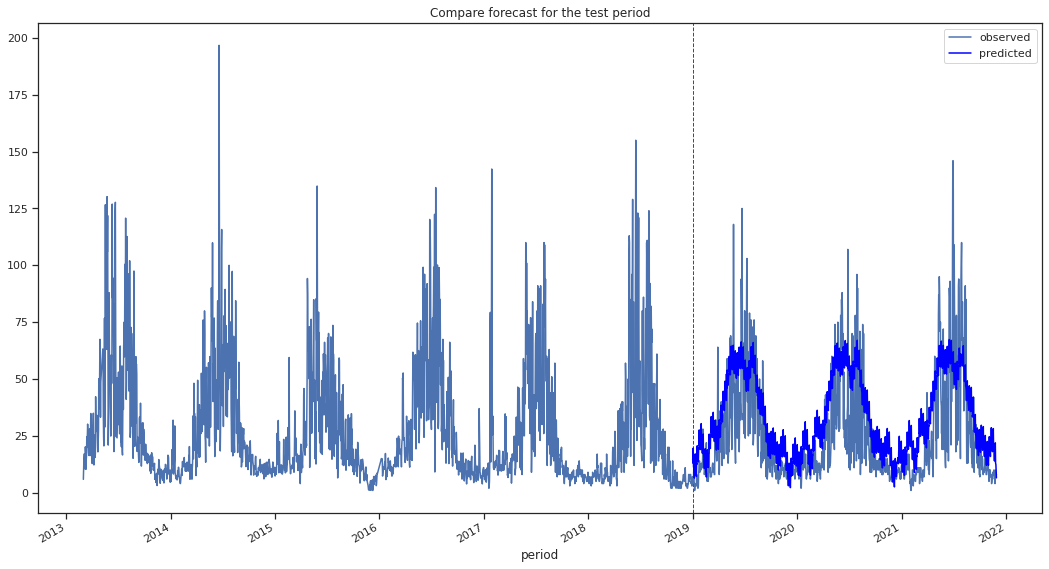

In [262]:
fig, ax = plt.subplots(figsize=(18,10))


plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.savefig('images/prophet-forecast-testrange.png')
plt.show();

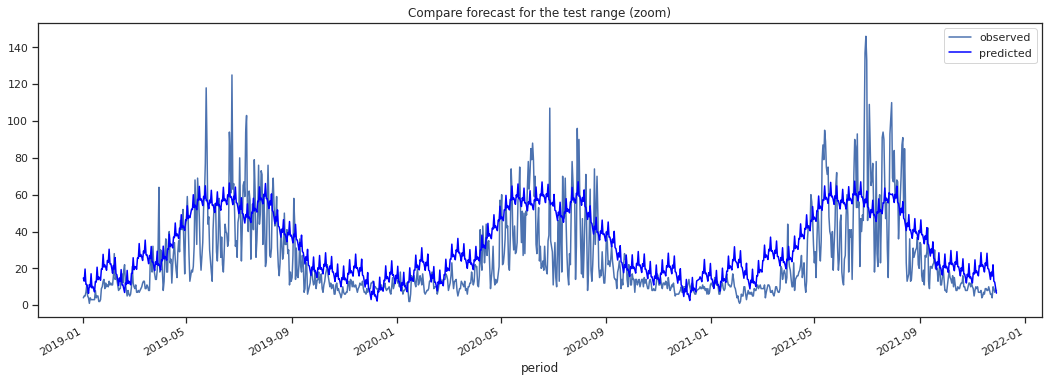

In [263]:
fig, ax = plt.subplots(figsize=(18,6))


df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('images/prophet-forecast-testrange-zoom.png')
plt.show();

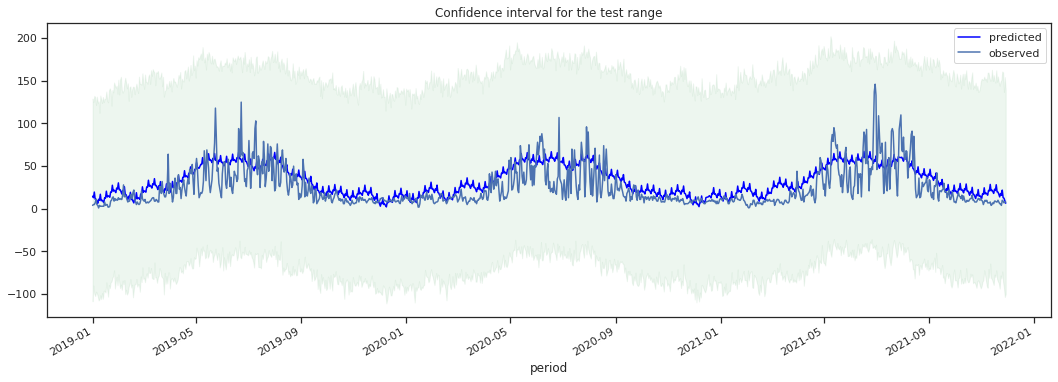

In [264]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('images/prophet-forecast-testrange-confidence-interval.png')
plt.show();

### Evaluate the forecast

In [265]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [266]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 13
MSE (test): 303
R2  (test): 0.389
U   (test): 0.014120
